# **零，連接Google Drive並設定工作目錄**

In [111]:

# the reference web of Colab with google drive : https://www.jianshu.com/p/ce2e63d1c10c
# 戴入檔案的方式， 
# COLAB  0:從Local端的路徑  
#       1:從Google Drive 中載入 

import os
from shutil import copyfile
from tqdm import tqdm
import time

IS_COLAB = 1

if IS_COLAB == 1:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
    !apt-get update -qq 2>&1 > /dev/null
    !apt-get -y install -qq google-drive-ocamlfuse fuse
    from google.colab import auth
    auth.authenticate_user()
    from oauth2client.client import GoogleCredentials
    creds = GoogleCredentials.get_application_default()
    import getpass
    !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
    vcode = getpass.getpass()
    !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

    !mkdir -p drive
    !google-drive-ocamlfuse drive

    # 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
    os.chdir("drive/Colab Notebooks/mpp/Automated Optical Inspection") 
    !ls
    
    # 將檔案從Google Drive複製一份至Cloab的本地Drive中，避免多次直接讀取Google Drive的檔案造成連線失敗的情況。
    print ("starting copy image files from google drive to local disk on colab ")
    HOME_DATA_DIR = os.path.join(os.path.abspath("/home"),"data")
    count=0
    if not os.path.exists(HOME_DATA_DIR):
      os.mkdir(HOME_DATA_DIR)
  
    denstination_list_dir = os.listdir(HOME_DATA_DIR)
    source_list_dir = os.listdir(".")
    
    # copy train data from google drive to the local disk of cloab 
    for dirpath, _ , filename in os.walk(os.path.join(os.path.abspath("."), "data-release/train")):  
      try:       
        x = tqdm(range(len(filename)))
        for i in x:
          dest_path = os.path.join(HOME_DATA_DIR,filename[i])
          if os.path.exists(dest_path) == False :
            copyfile(os.path.join(dirpath, filename[i]), os.path.join(HOME_DATA_DIR, filename[i]))      
          x.set_description("{}".format(filename[i]))
      except Exception as e:
        print ('Exception : '+ str(e))
      finally:
        x.close()
     
     # copy train data from google drive to the local disk of cloab 
    for dirpath, _ , filename in os.walk(os.path.join(os.path.abspath("."), "data-release/test")):  
      try:      
        x = tqdm(range(len(filename)))
        for i in x:
          dest_path = os.path.join(HOME_DATA_DIR,filename[i])
          if os.path.exists(dest_path) == False :
            copyfile(os.path.join(dirpath, filename[i]), os.path.join(HOME_DATA_DIR, filename[i]))      
          x.set_description("{}".format(filename[i]))
      except Exception as e:
        print ('Exception : '+ str(e))
      finally:
        x.close()
     

E: Package 'python-software-properties' has no installation candidate
aoi.ipynb  aoi.png  data-release  drive  logs
starting copy image files from google drive to local disk on colab 


test_00053.png: 100%|██████████| 10154/10154 [2:06:02<00:00,  1.46it/s]


# **一、 載入訓練資料並查看訓練資料的格式與內容**

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path as path
import gc
import os 

log_dir = os.path.join( path.abspath("."), "logs")
NAME = "aoi"
LABEL_COUNT = 6

train_path = path.join(path.abspath('.'), "data-release/train.csv")
train_dataframe = pd.read_csv(train_path) 
train_dataframe.info()

train_dataset = []
valid_dataset = []
train_data_ratio = 0.8
for i in range (LABEL_COUNT):    
    specific_labels = train_dataframe[train_dataframe['Label'] == i]     
    train_len = round(specific_labels.shape[0] * train_data_ratio)
    train_dataset.append(specific_labels[:train_len])
    valid_dataset.append(specific_labels[train_len:])
    
for i in range(LABEL_COUNT):
    print ("label:", i)
    print ("the length of train data:", train_dataset[i].shape[0])
    print ("the length of valid data:", valid_dataset[i].shape[0])
    
del train_dataframe
gc.collect()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2528 entries, 0 to 2527
Data columns (total 2 columns):
ID       2528 non-null object
Label    2528 non-null int64
dtypes: int64(1), object(1)
memory usage: 39.6+ KB
label: 0
the length of train data: 539
the length of valid data: 135
label: 1
the length of train data: 394
the length of valid data: 98
label: 2
the length of train data: 80
the length of valid data: 20
label: 3
the length of train data: 302
the length of valid data: 76
label: 4
the length of train data: 192
the length of valid data: 48
label: 5
the length of train data: 515
the length of valid data: 129


20745

# **二、 運用semi-supervised learning的方式, 載入機率大於0.95的測試資料在為測試及驗證資料**

In [113]:
retrain_path = path.join(path.abspath('.'), "data-release/retrain2.csv")
print(retrain_path)
#9020  9573
if path.exists(retrain_path): 
  retrain_dataframe = pd.read_csv(retrain_path)
  #retrain_dataframe.info()
  retrain_dataframe = retrain_dataframe[retrain_dataframe['predict']>0.95]
  print (retrain_dataframe.shape[0])
  
  for i in range (LABEL_COUNT):    
    specific_labels = retrain_dataframe[["ID", "Label"]][retrain_dataframe['Label'] == i] 
    print ("{} class on test dataset :{}".format(i, specific_labels.shape[0]))
    train_len = round(specific_labels.shape[0] * train_data_ratio)    
    train_dataset[i] = train_dataset[i].append(specific_labels[:train_len], ignore_index=True)
    valid_dataset[i] = valid_dataset[i].append(specific_labels[train_len:], ignore_index=True)    
    
  for i in range(LABEL_COUNT):
    print ("label:", i)
    print ("the length of train data:", train_dataset[i].shape)
    print ("the length of valid data:", valid_dataset[i].shape) 
 
  del retrain_dataframe
  gc.collect()

/content/drive/Colab Notebooks/mpp/Automated Optical Inspection/drive/Colab Notebooks/mpp/Automated Optical Inspection/data-release/retrain2.csv
9020
0 class on test dataset :2581
1 class on test dataset :1779
2 class on test dataset :400
3 class on test dataset :1448
4 class on test dataset :864
5 class on test dataset :1948
label: 0
the length of train data: (2604, 2)
the length of valid data: (651, 2)
label: 1
the length of train data: (1817, 2)
the length of valid data: (454, 2)
label: 2
the length of train data: (400, 2)
the length of valid data: (100, 2)
label: 3
the length of train data: (1460, 2)
the length of valid data: (366, 2)
label: 4
the length of train data: (883, 2)
the length of valid data: (221, 2)
label: 5
the length of train data: (2073, 2)
the length of valid data: (519, 2)


In [114]:
import math

train_dataset_maximum = max ([train_dataset[i].shape[0] for i in range(len(train_dataset))])
valid_dataset_maximum = max ([valid_dataset[i].shape[0] for i in range(len(valid_dataset))])
print ("the maximum length of train dataset:", train_dataset_maximum)
print ("the maximum length of valid dataset:", valid_dataset_maximum)

for i in range(LABEL_COUNT):
    difference = abs(train_dataset[i].shape[0] - train_dataset_maximum)
    repeat_count = math.floor(difference / train_dataset[i].shape[0])
    remain_count = difference - repeat_count * train_dataset[i].shape[0]   
    data_len = train_dataset[i].shape[0]
    for rc in range(repeat_count):       
        train_dataset[i] = train_dataset[i].append(train_dataset[i][:data_len], ignore_index=True)
    train_dataset[i] = train_dataset[i].append( train_dataset[i][:remain_count], ignore_index=True)
    
for i in range(LABEL_COUNT):
    difference = abs(valid_dataset[i].shape[0] - valid_dataset_maximum)
    repeat_count = math.floor(difference / valid_dataset[i].shape[0])
    remain_count = difference - repeat_count * valid_dataset[i].shape[0]     
    data_len = valid_dataset[i].shape[0]
    for rc in range(repeat_count):       
        valid_dataset[i] = valid_dataset[i].append(valid_dataset[i][:data_len], ignore_index=True)
    valid_dataset[i] = valid_dataset[i].append(valid_dataset[i][:remain_count], ignore_index=True)
    
for i in range(LABEL_COUNT):
    print ("label:", i)
    print ("the length of train data:", train_dataset[i].shape[0])
    print ("the length of valid data:", valid_dataset[i].shape[0])

the maximum length of train dataset: 2604
the maximum length of valid dataset: 651
label: 0
the length of train data: 2604
the length of valid data: 651
label: 1
the length of train data: 2604
the length of valid data: 651
label: 2
the length of train data: 2604
the length of valid data: 651
label: 3
the length of train data: 2604
the length of valid data: 651
label: 4
the length of train data: 2604
the length of valid data: 651
label: 5
the length of train data: 2604
the length of valid data: 651


# **三、對訓練及驗證資料集進行資料的預處理及資料增強(Data Augmentation)並顯示圖片內容**

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os, gc, psutil
import cv2

IMAGE_WIDTH = 512//2
IMAGE_HEIGHT = 512//2
        
def display_image(image_list, image_label, index_base=0 , title = "display image", save_image=False): 
    fig, ax = plt.subplots(figsize=(22 , 12))
    fig.subplots_adjust(hspace=0.4, wspace=0.1)
    DISPLAY_IMAGE_ROW = 3
    DISPLAY_IMAGE_COLUMN = 7
    
    for i in range(DISPLAY_IMAGE_ROW * DISPLAY_IMAGE_COLUMN):        
        plt.subplot(DISPLAY_IMAGE_ROW, DISPLAY_IMAGE_COLUMN, i + 1) 
        plt.imshow(image_list[i+index_base].reshape(IMAGE_HEIGHT, IMAGE_WIDTH) , cmap="gray")        
        plt.title("image : {}".format(image_label[i+index_base]))
        plt.axis("off")   
     
    plt.suptitle(title) 
    
    if save_image:
        plt.savefig('{}.png'.format(title))
        
def display_image_by_path(image_name, image_label, start_index=0 , scale=1.0, title = "display image", save_image=False): 
    fig, ax = plt.subplots(figsize=(22 , 6))
    fig.subplots_adjust(hspace=0.4, wspace=0.1)
    DISPLAY_IMAGE_ROW = 1
    DISPLAY_IMAGE_COLUMN = 7
    for i in range(DISPLAY_IMAGE_COLUMN):      
        file_name = get_file_path(image_name[start_index+i])       
        
        plt.subplot(2, DISPLAY_IMAGE_COLUMN, i + 1) 
        img = cv2.imread(file_name, 0)          
        img = cv2.resize(img, ((int)(img.shape[0] * scale), (int)(img.shape[1] * scale)))        
        
        plt.imshow(img, cmap="gray")         
        plt.title("image : {}".format(image_label[start_index+i]))
        plt.axis("off")
    
    plt.suptitle(title) 
    
    if save_image:
        plt.savefig('{}.png'.format(title))
        
        
def get_file_path(file_name):        
  if IS_COLAB == 1:
    full_path = path.join(HOME_DATA_DIR, file_name)    
  else:
    if "test" in file_name:   # file_name.contains("test"):
      full_path = path.join(path.abspath('./data-release/test'), file_name)
    else:
      full_path = path.join(path.abspath('./data-release/train'), file_name)
  return full_path

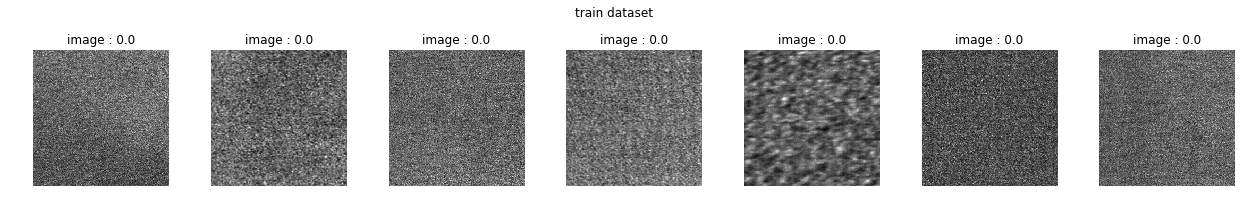

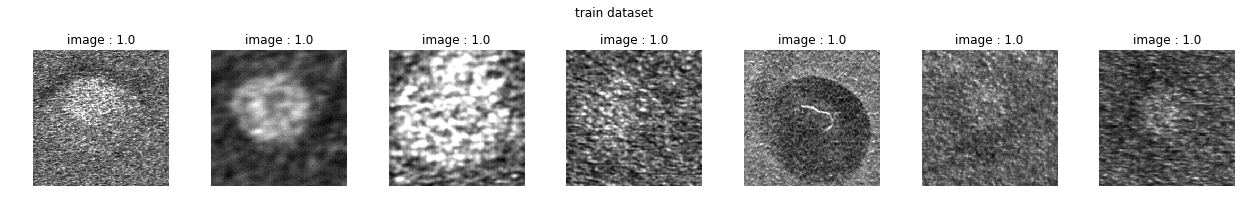

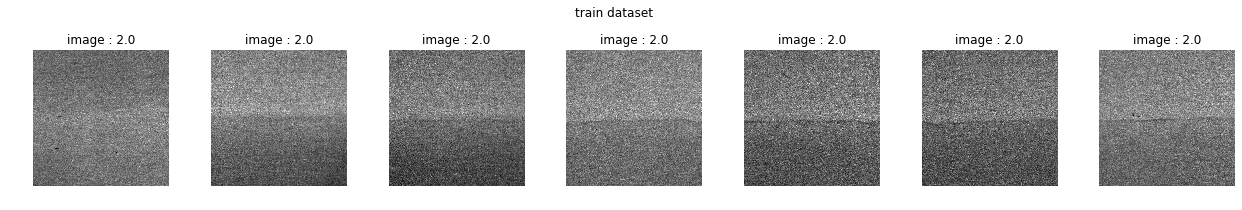

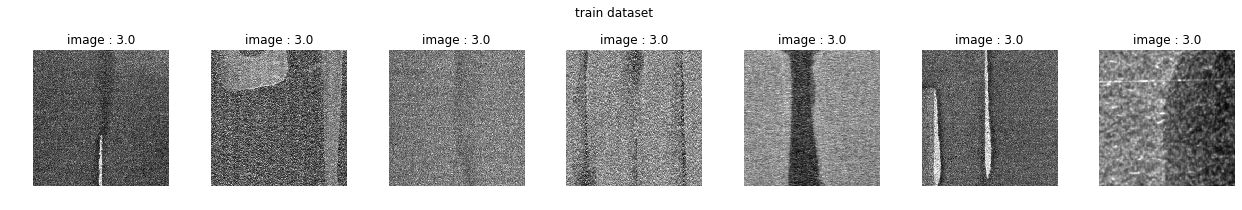

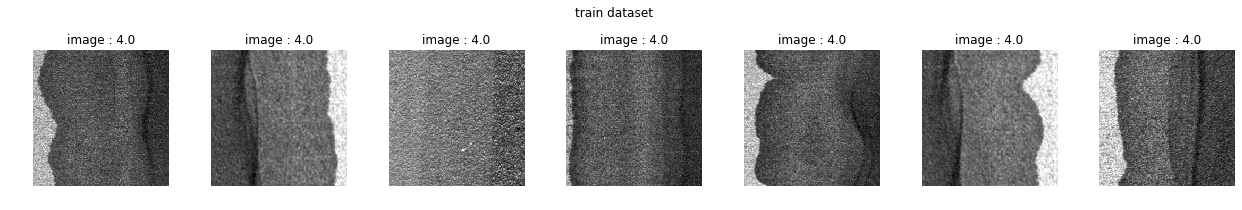

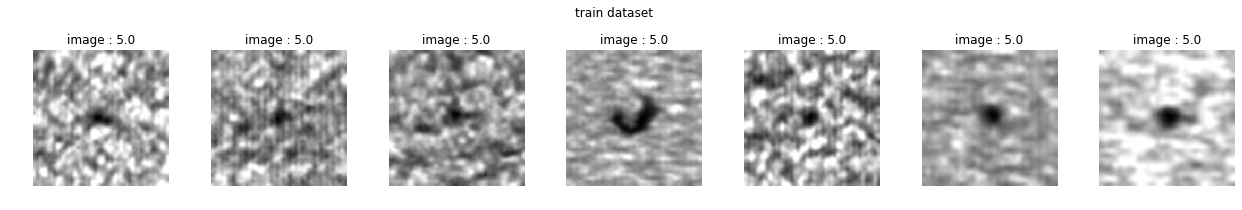

In [6]:
for i in range(LABEL_COUNT):
    display_image_by_path(train_dataset[i]["ID"], train_dataset[i]["Label"], scale=0.5, title="train dataset")  

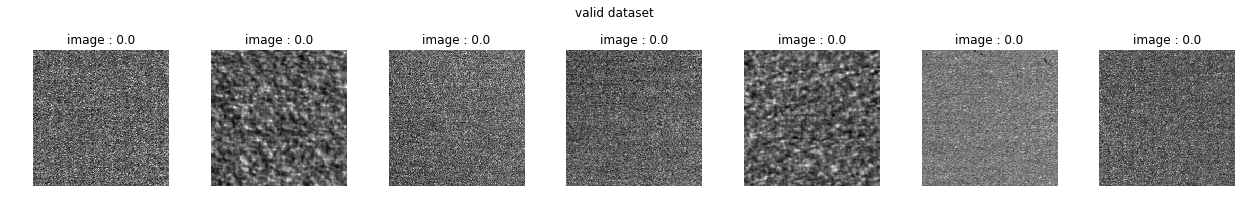

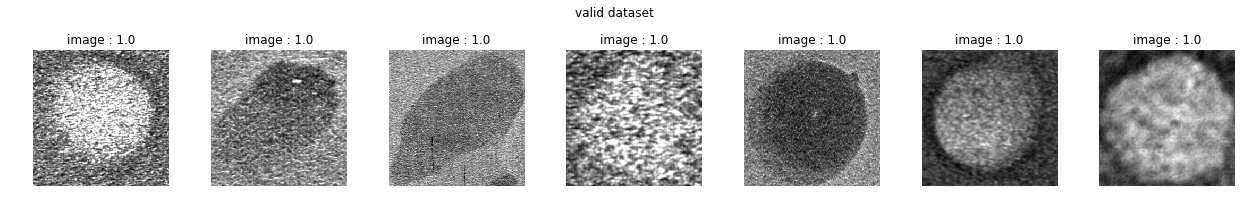

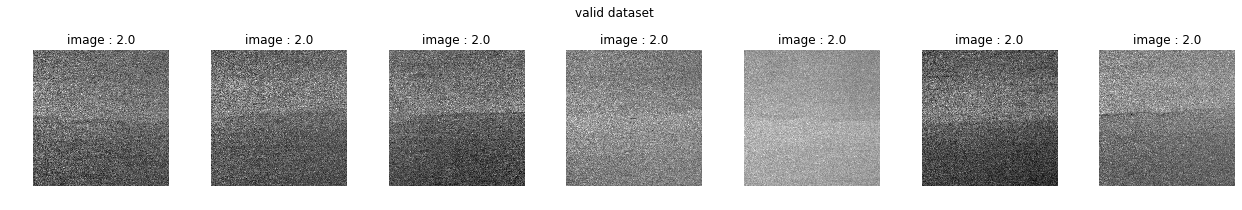

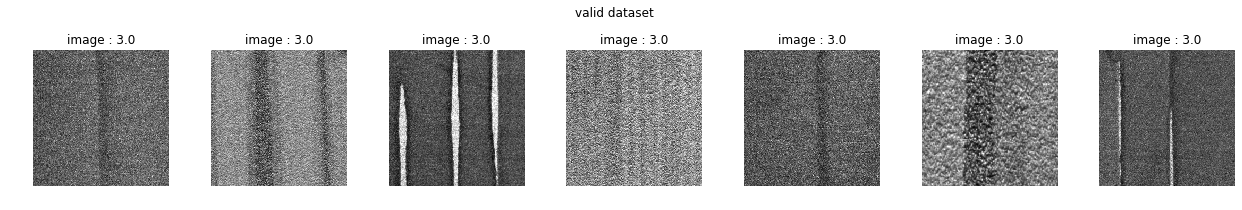

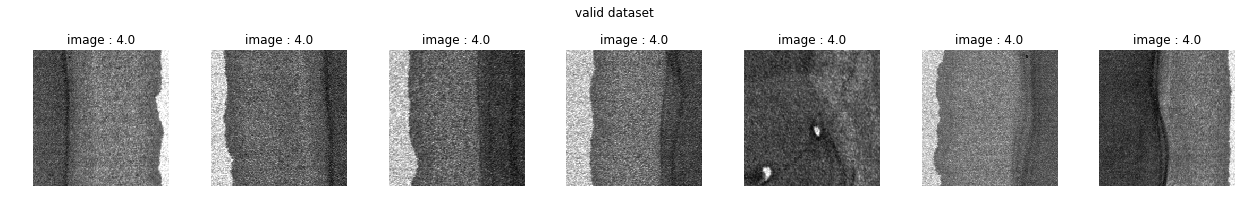

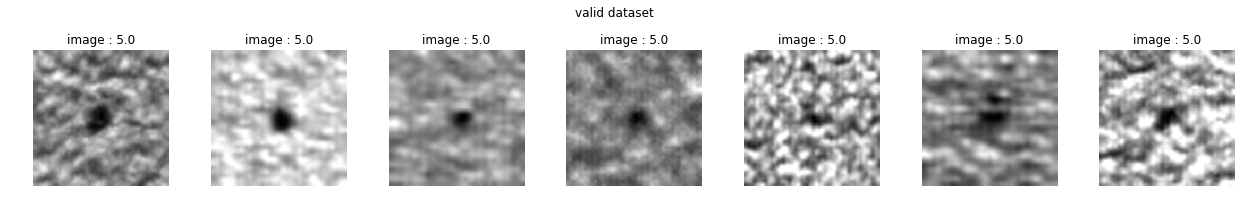

In [7]:
for i in range(LABEL_COUNT):
    display_image_by_path(valid_dataset[i]["ID"], valid_dataset[i]["Label"], scale=0.5, title="valid dataset") 

In [0]:
from keras.preprocessing.image import ImageDataGenerator
import keras
import math
import random 

BATCH_SIZE = 24

def data_generator(dataset, set_batch_size, shuffle = True, is_augment = True, normalization = False):

    # 依據批次訓練的樣本數計算最少需要的批次的次數
    batch_count = math.floor(dataset[0].shape[0] / set_batch_size)
    
    # 實際可整除批次訓練數量的樣本數
    sample_data_len = batch_count * set_batch_size
    
    # 建立訓練資料的引索值        
    shuffle_data_index = np.arange(dataset[0].shape[0])
       
    while True: 
        # 重新排列資料索引順序
        if shuffle:
            np.random.shuffle(shuffle_data_index)           
     
        # 依據批次訓練的數量reshape資料索引的格式
        data_index = shuffle_data_index[0:set_batch_size * batch_count].reshape(-1,set_batch_size)          
      
        batch_image = [] 
        batch_labels = []  
        
        for epoch_index in range(batch_count):      
            batch_image.clear()
            batch_labels.clear()
            random_seed = np.random.randint(0, 1024)    
            for i, index in enumerate(data_index[epoch_index]): 
                file_name = get_file_path(dataset[0][index])
                
                if not path.exists(file_name):  
                  print (file_name)
                  continue
                
                img = cv2.imread(file_name, 0) # 0, gragy                 
                       
                if img is None:
                  print ("not read image")
                  continue
                  
                if is_augment:
                  # 設定新增訓練影像的相關參數 
                  # 1. resize & clip image
                  re = random.sample([0, 32, 64, 128, 256], k=1)[0]                
                  img = cv2.resize(img, (IMAGE_HEIGHT + re ,IMAGE_WIDTH + re))
                  shift = re//2                        
                  img = img[shift:IMAGE_HEIGHT+shift, shift:IMAGE_WIDTH+shift]
                
                  # blur image 
                  ks = random.sample([0,3,5,7,9], k=1)[0]
                  kernel_size = (ks, ks)
                  sigma = random.uniform(0, 3)                   
                  img = cv2.GaussianBlur(img, kernel_size, sigma)                
                else:
                  img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
                  
                batch_image.append(img.reshape(IMAGE_HEIGHT, IMAGE_WIDTH,1))                 
                batch_labels.append(dataset[1][index])
                
            img_array = np.array(batch_image)             
            batch_img = img_array
            
            if normalization:
                batch_img = batch_img / 255            
            
            yield [batch_img], [np.array(batch_labels)]  

In [0]:
images_path = np.array(train_dataset[0]['ID'])
images_label = np.array(train_dataset[0]['Label'].astype('int64'))
 
for i in range(1,LABEL_COUNT):
    images_path = np.append(images_path, np.array(train_dataset[i]['ID']))
    images_label = np.append(images_label, np.array(train_dataset[i]['Label'].astype('int64')))
    
images_label = np.eye(6)[images_label]
train_gen = data_generator((images_path, images_label), BATCH_SIZE, shuffle=True, is_augment= True, normalization = True)
batch_images, batch_labels = next(train_gen)  
display_image(batch_images[0], batch_labels[0], title="train dataset", index_base=0)

In [0]:
images_path = np.array(valid_dataset[0]['ID'])
images_label =np.array(valid_dataset[0]['Label'].astype("int64"))
for i in range(1,LABEL_COUNT):
    images_path = np.append(images_path, np.array(valid_dataset[i]['ID']))
    images_label = np.append(images_label, np.array(valid_dataset[i]['Label'].astype("int64")))

images_label = np.eye(6)[images_label]
valid_gen = data_generator((images_path, images_label), BATCH_SIZE, shuffle=True, is_augment=True, normalization = True)
batch_images, batch_labels = next(valid_gen)
display_image(batch_images[0], batch_labels[0], title="valid dataset", index_base=0)
 

# **四、建立訓練模型**

In [0]:
import keras
import keras.layers as KL
import keras.models as KM
from keras import regularizers
from keras.utils.vis_utils import plot_model

import keras
import keras.layers as KL
import keras.models as KM
from keras import regularizers

def use_customized_network(save_graphic=False):
    
    image_input = keras.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 1], dtype="float32")  
         
    x = KL.Conv2D(128, (3,3), padding="same", strides= 1, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01))(image_input)
    x = KL.BatchNormalization()(x)
    x1 = KL.Activation("relu")(x) 
    
    x = KL.Conv2D(128, (5,5), padding="same", strides= 1, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01))(image_input)
    x = KL.BatchNormalization()(x)
    x2 = KL.Activation("relu")(x) 
    
    x = KL.concatenate([x1, x2])
    
    x = KL.Conv2D(64, (1,1), padding="same", strides = 1, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01))(x)
    x = KL.BatchNormalization()(x)
    x = KL.Activation("relu")(x)
    
    # 1/2
    x = KL.Conv2D(128, (3,3), padding="same", strides =2, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01))(x)
    x = KL.BatchNormalization()(x)
    x = KL.Activation("relu")(x)
    # x = KL.Dropout(0.5)(x)   
   
    x = KL.Conv2D(64, (1,1), padding="same", strides = 1, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01))(x)
    x = KL.BatchNormalization()(x)
    x = KL.Activation("relu")(x)
    # x = KL.Dropout(0.5)(x)
    
    # 1/4
    x = KL.Conv2D(128, (3,3), padding="same", strides = 2, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01))(x)
    x = KL.BatchNormalization()(x)
    x = KL.Activation("relu")(x)
    # x = KL.Dropout(0.5)(x)    
   
    x = KL.Conv2D(64, (1,1), padding="same", strides = 1, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01))(x)
    x = KL.BatchNormalization()(x)
    x = KL.Activation("relu")(x)
    # x = KL.Dropout(0.5)(x)  
     
    # 1/ 8  
    x = KL.Conv2D(128, (3,3), padding="same", strides = 2, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01))(x)
    x = KL.BatchNormalization()(x)
    x = KL.Activation("relu")(x)
    
    x = KL.Conv2D(64, (1,1), padding="same", strides = 1, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01))(x)
    x = KL.BatchNormalization()(x)
    x1 = x = KL.Activation("relu")(x)
     
    # 1/ 16  
    x = KL.Conv2D(128, (3,3), padding="same", strides = 2, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01))(x)
    x = KL.BatchNormalization()(x)
    x = KL.Activation("relu")(x)
     
    x = KL.Conv2D(64, (1,1), padding="same", strides = 1, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01))(x)
    x = KL.BatchNormalization()(x)
    x2 = x = KL.Activation("relu")(x)
     
    
    # 1/ 32
    x = KL.Conv2D(128, (3,3), padding="same", strides = 2, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01))(x)
    x = KL.BatchNormalization()(x)
    x = KL.Activation("relu")(x)
    #x = KL.Dropout(0.5)(x)  
    
    x = KL.Conv2D(64, (1,1), padding="same", strides = 1, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01))(x)
    x = KL.BatchNormalization()(x)
    x3 = x = KL.Activation("relu")(x)
    
    # 1/ 64
    x = KL.Conv2D(128, (3,3), padding="same", strides = 2, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01))(x)
    x = KL.BatchNormalization()(x)
    x = KL.Activation("relu")(x)
    # x = x= KL.Dropout(0.5)(x)  
    
    x = KL.Conv2D(64, (1,1), padding="same", strides = 1, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01))(x)
    x = KL.BatchNormalization()(x)
    x = KL.Activation("relu")(x)
    
    x = KL.GlobalAveragePooling2D()(x)    # 1/64
    x1 =  KL.GlobalAveragePooling2D()(x1) # 1/8
    x2 =  KL.GlobalAveragePooling2D()(x2) # 1/16
    x3 =  KL.GlobalAveragePooling2D()(x3) # 1/32
    
    x = KL.concatenate([x, x1])
    x = KL.concatenate([x, x2])
    x = KL.concatenate([x, x3])
    
    merge_output = KL.Dense(6, activation='softmax')(x)

    model = KM.Model (inputs = [image_input], outputs = [merge_output], name='predict_aoi')
 
    optimizer_adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.2)
   
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
     
    if save_graphic: 
      # Create model object in inference mode. inference training
      plot_model(model, to_file="aoi.png", show_shapes=True, show_layer_names=True)
  
    return model  
  

In [0]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,CSVLogger, ReduceLROnPlateau, EarlyStopping
import datetime

np.random.seed(7718)

# Path to save after each epoch. Include placeholders that get filled by Keras.
save_model_path = os.path.join(log_dir, "{}_*epoch*_*loss*.h5".format(NAME.lower()))    
save_model_path = save_model_path.replace("*epoch*", "{epoch:04d}")
save_model_path = save_model_path.replace("*loss*", "{val_loss:04f}") 

save_log_path = os.path.join(log_dir, "{}_loss.csv".format(NAME.lower()))
if os.path.exists(save_log_path):
    os.remove(save_log_path)
  
#earlystop = EarlyStopping(monitor='val_loss', patience=50, mode='auto')
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto', min_delta=0.001, cooldown=0, min_lr=0.00001)  
msave = ModelCheckpoint(save_model_path, monitor='val_loss', mode='min', save_best_only=False, save_weights_only=False)
csv = CSVLogger(save_log_path, append=True)

initial_step = 0
load_model_path = os.path.join(log_dir, "aoi{:04}.h5".format(initial_step))
print (load_model_path)

if path.exists(load_model_path):  
    model = load_model(load_model_path)
else:
    model = use_customized_network()
    
model.fit_generator(
            train_gen,
            initial_epoch = initial_step,
            epochs = 500,
            steps_per_epoch= 300,
            callbacks = [csv, msave, reducelr], #earlystop
            validation_data = valid_gen,
            validation_steps = 50,
            max_queue_size = 100,
            workers = 0, # only for windows 
            use_multiprocessing=True)


# **五，載入訓練的最佳模型及分析結果**

In [120]:
# 設定模型的檔案路徑及載入模型
import os
from keras.models import load_model
FILE_NAME = "keep/aoi_0228.h5"
model_path = os.path.join(log_dir, FILE_NAME )
if not path.exists(model_path):   
    print (model_path)    
    raise ValueError ("File is not exists. - {}".format(model_path))

predict_model = load_model(model_path)
predict_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 128 1280        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 128 3328        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 128 512         conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import itertools

from sklearn.metrics import roc_curve, auc   

def display_roc_curve(predict_result, target_result, caption="Receiver Operating Characteristic Curve"):  
    fpr, tpr, _ = roc_curve(target_result, predict_result)   
    label_list = "area under curve :{}".format(round(auc(fpr, tpr),2))
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',lw=2, label= label_list) 
    plt.plot([0.0,1],[0,1], color='navy',lw=2)   
    plt.xlim([0.0, 1.0])  # 設定X軸的刻度
    plt.ylim([0.0, 1.02]) # 設定Y軸的刻度且為了避免1.0的線與圖的外框相連，因此多出0.02
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(caption)
    plt.legend(loc='lower right') # 設定線段說明的位置
    plt.show()
    
def display_mulitclass_roc_curve(roc_dict, caption , LABEL_COUNT):  
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    true_dict = np.array(roc_dict[0] )
    predict_dict = np.array(roc_dict[1])
    
    for i in range(LABEL_COUNT):     
      fpr[i], tpr[i], _ = roc_curve(true_dict[:,i], predict_dict[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure() 
    colors = itertools.cycle(['darkorange', 'black', 'green', "black", "red", "cyan", "yellow", "magenta"])
    for i, color in zip(range(LABEL_COUNT), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0.0,1],[0,1], color='navy',lw=2)   
    plt.xlim([0.0, 1.0])  # 設定X軸的刻度
    plt.ylim([0.0, 1.02]) # 設定Y軸的刻度且為了避免1.0的線與圖的外框相連，因此多出0.02
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(caption)  
    plt.legend(loc="lower right")
    plt.show()    
    
def display_error_image(images, targets, predicts, display_indexs, title ="diisplay error image" ):  
    fig, ax = plt.subplots(figsize=(22 , 6))
    fig.subplots_adjust(hspace=0.4, wspace=0.1)   
 
    for i, index in enumerate(display_indexs):
        if (i >= DISPLAY_IMAGE): break;
        plt.subplot(2, DISPLAY_IMAGE, i + 1)       
        plt.title("image:{}-{:.8f}".format(targets[index][0], predicts[index][0]))
        plt.axis("off")
        plt.imshow(images[index]) 
   
    for i, index in enumerate(display_indexs): 
        if (i >= DISPLAY_IMAGE): break;
        plt.subplot(2, DISPLAY_IMAGE, i + DISPLAY_IMAGE + 1)      
        plt.title("image:{}-{:.8f}".format(targets[index][0], predicts[index][0])) 
        plt.axis("off")  
        plt.imshow(images[index]) 
    
    plt.suptitle = title
    

In [99]:
 
#train_path = path.join(path.abspath('.'), "data-release/train.csv")
train_dataframe = pd.read_csv(train_path) 
train_dataframe.info()

train_images_path = []
train_images_label = []

valid_images_path = []
valid_images_label = []

train_data_ratio = 0.8
for i in range (LABEL_COUNT):    
    specific_labels = train_dataframe[train_dataframe['Label'] == i]   
    train_len = round(specific_labels.shape[0] * train_data_ratio)    
    
    train_images_path.append(np.array(specific_labels[:train_len]['ID']))
    train_images_label.append(np.eye(6)[specific_labels[:train_len]['Label']])
    
    valid_images_path.append(np.array(specific_labels[train_len:]['ID']))
    valid_images_label.append(np.eye(6)[specific_labels[train_len:]['Label']])
    
for i in range(LABEL_COUNT):
    print ("label:", i)
    print ("the length of train data:", train_dataset[i].shape[0])
    print ("the length of valid data:", valid_dataset[i].shape[0])
    
    
del train_dataframe
gc.collect()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2528 entries, 0 to 2527
Data columns (total 2 columns):
ID       2528 non-null object
Label    2528 non-null int64
dtypes: int64(1), object(1)
memory usage: 39.6+ KB
label: 0
the length of train data: 2604
the length of valid data: 651
label: 1
the length of train data: 2604
the length of valid data: 651
label: 2
the length of train data: 2604
the length of valid data: 651
label: 3
the length of train data: 2604
the length of valid data: 651
label: 4
the length of train data: 2604
the length of valid data: 651
label: 5
the length of train data: 2604
the length of valid data: 651


28334

=== Train Dataset ===


100%|██████████| 515/515 [00:11<00:00, 43.42it/s]


loss :  0.04601257078489611
accuracy : 0.9990108803165183


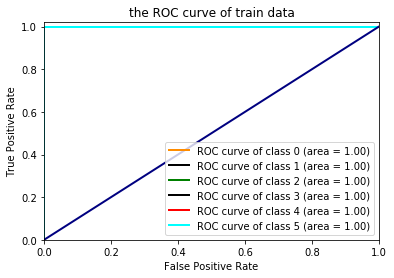

=== the confusion matrix of train data ====
   normal  void  horizontal  vertical defect  edge defect  particle
0     538     0           1                0            0         0
1       0   393           0                1            0         0
2       0     0          80                0            0         0
3       0     0           0              302            0         0
4       0     0           0                0          192         0
5       0     0           0                0            0       515


                 precision    recall  f1-score   support

         normal       1.00      1.00      1.00       539
           void       1.00      1.00      1.00       394
     horizontal       0.99      1.00      0.99        80
vertical defect       1.00      1.00      1.00       302
    edge defect       1.00      1.00      1.00       192
       particle       1.00      1.00      1.00       515

       accuracy                           1.00      2022
      macro avg     

In [97]:
from tqdm import tqdm
import time
import seaborn as sn   
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

# 評估模型
roc_dict={}
data_result = []

# 評估Train Dataset的loss值及正確率
print ("=== Train Dataset ===")
time.sleep(1)
loss_value = 0
accuray_value = 0 
roc_dict["train"] = [[],[]]
total_count = 0

try:
    for i in range(LABEL_COUNT):
      x = tqdm(range(len(train_images_path[i])))
      #x = tqdm(range(10))
      for index in x:
        full_path = get_file_path(train_images_path[i][index])    
        if path.exists(full_path):
            img = cv2.imread(full_path, 0) 
            img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
            img = img / 255
            img = img.reshape(IMAGE_HEIGHT, IMAGE_WIDTH,1)            
            img = np.expand_dims(img, axis=0)    
             
            predict = predict_model.predict(x=img) 
            
            roc_dict['train'][0].append(train_images_label[i][index]) 
            roc_dict['train'][1].append(predict[0])            
            
            image_label = np.expand_dims(train_images_label[i][index], axis=0)            
            predict_result = predict_model.evaluate(x=img, y=image_label, batch_size=1, verbose=0)   
            loss_value = loss_value + predict_result[0]
            accuray_value = accuray_value + predict_result[1]        
            total_count+=1    
except Exception as ex:
    print ("Exception:" + str(ex))
finally:
    x.close()
    
print ("loss : ", loss_value/total_count)
print ("accuracy :", accuray_value/total_count)

# 建立ROC Curve (Receiver Operating Characteristic Curve)

display_mulitclass_roc_curve(roc_dict['train'], caption="the ROC curve of train data", LABEL_COUNT = LABEL_COUNT) 
  
# 建立Confusion Matrix
target_names = ['normal','void','horizontal','vertical defect','edge defect','particle'] 

train_true_labels=[]
train_pred_labels=[]

for i in range(len(roc_dict['train'][0])):
  train_true_labels.extend([np.argmax(roc_dict['train'][0][i])])
  train_pred_labels.extend([np.argmax(roc_dict['train'][1][i])])    

print ("=== the confusion matrix of train data ====")
cm = confusion_matrix(y_true=train_true_labels, y_pred=train_pred_labels)

print(pd.DataFrame(cm, columns=target_names))
print ("\n")
print(classification_report(train_true_labels, train_pred_labels, target_names=target_names)) 


=== Validation Dataset ===


100%|██████████| 129/129 [00:02<00:00, 43.82it/s]


loss :  0.06759349627810504
accuracy : 0.9920948616600791


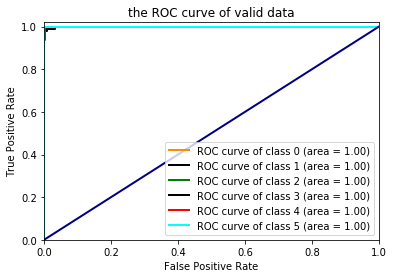


=== the confusion matrix of valid data ====
   normal  void  horizontal  vertical defect  edge defect  particle
0     270     0           0                0            0         0
1       0   192           0                4            0         0
2       0     0          40                0            0         0
3       0     0           0              150            2         0
4       0     0           0                0           96         0
5       0     2           0                0            0       256


                 precision    recall  f1-score   support

         normal       1.00      1.00      1.00       270
           void       0.99      0.98      0.98       196
     horizontal       1.00      1.00      1.00        40
vertical defect       0.97      0.99      0.98       152
    edge defect       0.98      1.00      0.99        96
       particle       1.00      0.99      1.00       258

       accuracy                           0.99      1012
      macro avg    

In [98]:
# 評估Validation Dataset的loss值及正確率
print ("=== Validation Dataset ===")
time.sleep(1)
total_count = 0
loss_value = 0
accuray_value = 0 
roc_dict["valid"] = [[],[]]

try:
    for i in range(LABEL_COUNT):
      true_label = []
      predict_label =[]
      x = tqdm(range(len(valid_images_path[i])))
      for index in x:
        full_path = get_file_path(valid_images_path[i][index])               
        if path.exists(full_path):
            img = cv2.imread(full_path, 0)  
            img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
            img = img /255
            img = img.reshape(IMAGE_HEIGHT, IMAGE_WIDTH,1)         
            img = np.expand_dims(img, axis=0) 
            
            predict = predict_model.predict(x=img)    
          
            roc_dict['valid'][0].append(valid_images_label[i][index]) 
            roc_dict['valid'][1].append(predict[0])   
            image_label = np.expand_dims(valid_images_label[i][index], axis=0)      
            
            predict_result = predict_model.evaluate(x=img, y=image_label, batch_size=1, verbose=0)          
            loss_value = loss_value + predict_result[0]  
            accuray_value = accuray_value + predict_result[1] 
            total_count+=1
            
except Exception as ex:
    print ("exception:" + str(ex))
finally:
    x.close()
    
print ("loss : ", loss_value/total_count)
print ("accuracy :", accuray_value/total_count)
    
# 建立ROC Curve (Receiver Operating Characteristic Curve)
display_mulitclass_roc_curve(roc_dict['valid'], caption="the ROC curve of valid data", LABEL_COUNT = LABEL_COUNT)

# 建立Confusion Matrix

valid_true_labels=[]
valid_pred_labels=[]

for i in range(len(roc_dict['valid'][0])):
  valid_true_labels.extend([np.argmax(roc_dict['valid'][0][i])])
  valid_pred_labels.extend([np.argmax(roc_dict['valid'][1][i])])
  
print ("\n=== the confusion matrix of valid data ====") 
cm = confusion_matrix(y_true=valid_true_labels, y_pred=valid_pred_labels)
print (pd.DataFrame(cm, columns=target_names))
print ("\n")
print (classification_report(valid_true_labels, valid_pred_labels, target_names=target_names)) 

=== Test Dataset ===
=== Round 1 ===
320/320 [==============================] - 2s 7ms/step
loss :  0.0648586057126522
accuracy : 0.990625
=== Round 2 ===
320/320 [==============================] - 2s 7ms/step
loss :  0.0470288947224617
accuracy : 1.0
=== Round 3 ===
320/320 [==============================] - 2s 7ms/step
loss :  0.06267033554613591
accuracy : 0.990625
=== Round 4 ===
320/320 [==============================] - 2s 7ms/step
loss :  0.06270131729543209
accuracy : 0.984375
=== Round 5 ===
320/320 [==============================] - 2s 7ms/step
loss :  0.09361709766089917
accuracy : 0.978125
=== Round 6 ===
320/320 [==============================] - 2s 7ms/step
loss :  0.06675301566720009
accuracy : 0.9875
=== Round 7 ===
320/320 [==============================] - 2s 7ms/step
loss :  0.06581968143582344
accuracy : 0.9875
=== Round 8 ===
320/320 [==============================] - 2s 7ms/step
loss :  0.061170521378517154
accuracy : 0.99375
=== Round 9 ===
320/320 [=============

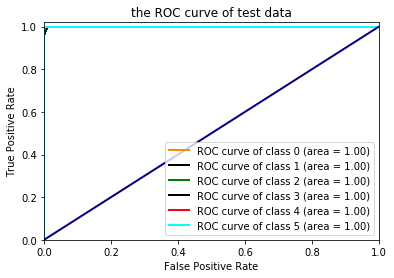


=== the confusion matrix of valid data ====
   normal  void  horizontal  vertical defect  edge defect  particle
0     519     1           0                0            0         0
1      12   523           0                7            0         1
2       0     0         537                0            0         0
3       3     2           0              524           12         0
4       1     0           0                0          527         0
5       0     0           0                0            0       531


                 precision    recall  f1-score   support

         normal       0.97      1.00      0.98       520
           void       0.99      0.96      0.98       543
     horizontal       1.00      1.00      1.00       537
vertical defect       0.99      0.97      0.98       541
    edge defect       0.98      1.00      0.99       528
       particle       1.00      1.00      1.00       531

       accuracy                           0.99      3200
      macro avg    

In [122]:
# 使用資料增強的方式產生Test Dataset進行評估loss值及正確率
print ("=== Test Dataset ===")
TEST_ECPOHS = 10

images_path = np.array(valid_dataset[0]['ID'])
images_label =np.array(valid_dataset[0]['Label'])
for i in range(1,LABEL_COUNT):
    images_path = np.append(images_path, np.array(valid_dataset[i]['ID']))
    images_label = np.append(images_label, np.array(valid_dataset[i]['Label']))

images_label = np.eye(LABEL_COUNT)[images_label.astype(int)]
test_gen = data_generator((images_path, images_label), 320, shuffle=True, is_augment=True, normalization = True)

Average_Loss = 0
Average_Accuracy = 0
roc_dict ={}
roc_dict["test"]=[[],[]]
 
for i in range (TEST_ECPOHS):
    print ("=== Round {} ===".format(i+1))  
    test_data , test_ans = next(test_gen)  
    
    # 使用predict方法取得判斷的機率值並存至roc_dict字典物件
    predict_result = predict_model.predict(x=test_data)     
    
    roc_dict["test"][0].extend(test_ans[0])
    roc_dict["test"][1].extend(predict_result)
    
    # 使用predict方法取得判斷的機率值
    predict_result = predict_model.evaluate(x=test_data, batch_size=32 , y=test_ans)  
    print ("loss : ", predict_result[0])
    print ("accuracy :", predict_result[1])
  
    Average_Loss += predict_result[0]
    Average_Accuracy += predict_result[1]

print ("=== Average evaluate ===")
print ("loss : ", Average_Loss / TEST_ECPOHS)
print ("accuracy :",Average_Accuracy / TEST_ECPOHS)

# 建立ROC Curve (Receiver Operating Characteristic Curve)
display_mulitclass_roc_curve(roc_dict["test"], caption="the ROC curve of test data", LABEL_COUNT = LABEL_COUNT)

# 建立Confusion Matrix
test_true_labels=[]
test_pred_labels=[]
for i in range(len(roc_dict['test'][0])):
  test_true_labels.extend([np.argmax(roc_dict['test'][0][i])])
  test_pred_labels.extend([np.argmax(roc_dict['test'][1][i])])
  
print ("\n=== the confusion matrix of valid data ====") 
cm = confusion_matrix(y_true=test_true_labels, y_pred=test_pred_labels)
print (pd.DataFrame(cm, columns=target_names))
print ("\n")
print (classification_report(test_true_labels, test_pred_labels, target_names=target_names)) 
 

# **六，產生上傳的Submisson檔案**

In [0]:
import time, datetime

test_path = path.join(path.abspath('.'), "data-release/test.csv")
test_dataframe = pd.read_csv(test_path) 
test_dataframe.info()
time.sleep(1)
predict_list = []
try: 
  x = tqdm(range(len(test_dataframe)))
  #x = tqdm(range(10))
  for i in x:    
    file_name = get_file_path(test_dataframe.loc[i, 'ID'])     
    if path.exists(file_name):
      img = cv2.imread(file_name, 0) 
      img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
      img = img.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, 1)
      img = img /255
      img = np.expand_dims(img, axis=0) 
      predict = predict_model.predict(x=img)     
      index = np.argmax(predict[0])
       
      test_dataframe.loc[i, 'Label'] = index
      test_dataframe.loc[i, 'predict']=predict[0][index]
  #test_dataframe["Label"]=predict_list    
except Exception as e:
  print ('Exception : '+ str(e))
finally:
  x.close()  

save_file = "./data-release/aoi{:%Y%m%d_%H%M}.csv".format(datetime.datetime.now())
test_dataframe[["ID","Label"]].to_csv(save_file, index=False)

retrain_file = "./data-release/retrain{:%Y%m%d_%H%M}.csv".format(datetime.datetime.now())
test_dataframe.to_csv(retrain_file, index=False)
print(test_dataframe.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10142 entries, 0 to 10141
Data columns (total 2 columns):
ID       10142 non-null object
Label    0 non-null float64
dtypes: float64(1), object(1)
memory usage: 158.5+ KB


100%|██████████| 10142/10142 [02:16<00:00, 74.13it/s]


               ID  Label   predict
0  test_00000.png    1.0  0.999996
1  test_00001.png    2.0  0.999963
2  test_00002.png    5.0  0.999793
3  test_00003.png    0.0  0.991492
4  test_00004.png    2.0  0.999985
